In [5]:
import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.text import Text
import seaborn as sns

import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import plot_functions as PF
import TrialAnalyses as TA
import analyses_table as AT
from importlib import reload  # Python 3.4+ only.

In [6]:
oakPaths = AT.getOakPaths()

In [7]:
sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})


In [76]:

#task = 'T3g'
animals = ['Li','Ne','Cl']
overwrite=False
doPlots = False

cols = ['se','an','task','nTrials','nDiscard','nCo','nInCo','nLD','nRD','nLC','nRC','nST','pCo','pCoST']
allBehDat = pd.DataFrame()
for animal in animals:    
    fn = oakPaths['Root'] / (animal+'_SessionPaths.pkl')
    with fn.open(mode="rb") as f:
        sePaths = pkl.load(f)

    CT_Path =  oakPaths['Clustered'] / animal / (animal+'_ClusteringSummary.json')
    with CT_Path.open() as f:
        CT = json.load(f)

    for se,v in CT['Sessions'].items():
        if v:
            try:
                temp = se.split('_')
                if temp[1][:2]=='T3':
                    TrialConds = pd.read_csv(sePaths[se]['TrialCondMat'] ,index_col=0)
                    X = TrialConds[TrialConds['Good']]
                    
                    behDat = pd.DataFrame(np.zeros((1,len(cols))),columns=cols )
                    behDat['se'] = se
                    behDat['an'] = animal
                    behDat['task'] = temp[1]

                    behDat['nTrials'] = X.shape[0]
                    behDat['nDiscard'] = np.sum(~TrialConds['Good'])
                    behDat['nCo'] = np.sum(X['Co']=='Co')
                    behDat['nInCo'] = np.sum(X['Co']=='InCo')
                    behDat['nLD'] = np.sum(X['Desc']=='L')
                    behDat['nRD'] = np.sum(X['Desc']=='R')
                    behDat['nLC'] = np.sum(X['Cues']=='L')
                    behDat['nRC'] = np.sum(X['Cues']=='R')

                    ST = ~(X['Cues'].values[0:-1]==X['Cues'].values[1:])
                    CoT = (X['Co']=='Co').values

                    behDat['nST'] = np.sum(ST)
                    behDat['pCo'] = np.mean(CoT)
                    behDat['pCoST'] = CoT[np.where(ST)[0]+1].mean()

                    allBehDat = pd.concat((allBehDat,behDat))
            except:
                print("Error processing session: {}".format(se))
                print ("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)
                pass


allBehDat.to_csv(oakPaths['Analyses'] / 'TaskBehavior.csv')

Error processing session: Li_T3i_060518
Error <class 'FileNotFoundError'> [Errno 2] File b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T3i_060518_Analyses/TrialCondMat.csv' does not exist: b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T3i_060518_Analyses/TrialCondMat.csv' 23
Error processing session: Li_T3i_060618
Error <class 'FileNotFoundError'> [Errno 2] File b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T3i_060618_Analyses/TrialCondMat.csv' does not exist: b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T3i_060618_Analyses/TrialCondMat.csv' 23
Error processing session: Li_T3i_060818
Error <class 'FileNotFoundError'> [Errno 2] File b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T3i_060818_Analyses/TrialCondMat.csv' does not exist: b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T3i_060818_Analyses/TrialCondMat.csv' 23
Error processing session: Li_T3i_061118
Error <class 'FileNotFoundError'> [Errno 2] File b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T3i_061118_Analyses/TrialCondMat.csv' does not exist: b'/mnt/o/giocomo/alexg/Analyses/Li/Li_T

In [90]:
allBehDat.to_csv(oakPaths['Analyses'] / 'TaskBehavior.csv')

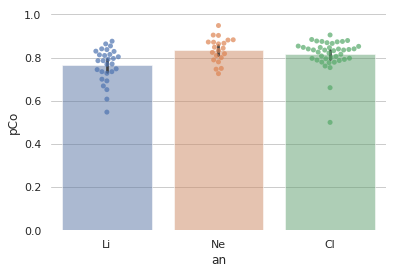

In [93]:


sns.barplot(x='an',y='pCo',data=allBehDat,alpha=0.5)
sns.swarmplot(x='an',y='pCo',data=allBehDat,alpha=0.7)



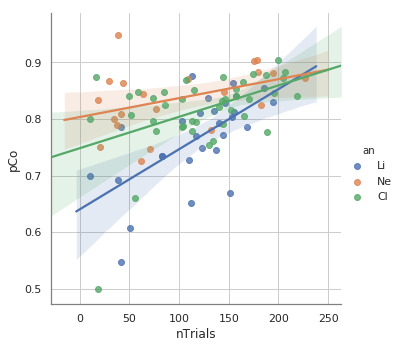

In [92]:
sns.lmplot(x='nTrials',y='pCo',hue='an',data=allBehDat)

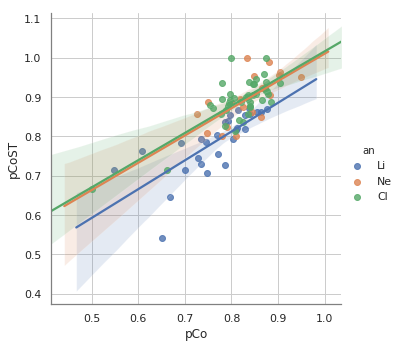

In [94]:
sns.lmplot(x='pCo',y='pCoST',hue='an',data=allBehDat)

In [53]:
behDat

,se,nTrials,nDiscard,nCo,nInCo,nLD,nRD,nLC,nRC,nST,pCo,pCoST
0,Li_T3g_062718,194,17,161,33,105,89,110,84,99,0.829897,0.818182
